# Initial investigation of drug-gene networks

** Brin Rosenthal (sbrosenthal@ucsd.edu) **  
** April 15, 2016**

### Prototype for tool to be added to Search 

### Goals:
- **Input a gene list**
- **Use the DrugBank database to suggest drugs related to genes in input list**

- Note: data files and code for this notebook may be found in the 'data' and 'source' directories

In [1]:
# import some useful packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx
import pandas as pd
import random
import json

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

% matplotlib inline

# Test drug_gene_heatprop module

- This section runs the inferred drug heat propagation module from a list of seed genes, and returns a list of genes ranked by their 'heat', or proximity to the seed gene set.  These are the genes which we think will be most related to the seed genes.


- For a more detailed, step by step description of the process, continue reading past this section.

In [2]:
# load the module
import sys
sys.path.append('../source')
import drug_gene_heatprop
import imp
imp.reload(drug_gene_heatprop)


ImportError: No module named drug_gene_heatprop

,drugs,heat_rank
RWDD4A,[],0
GRK4,[],1
LETM1,[],2
RPL3,"[DB02494, DB08437, DB04865, DB07374]",3
RPS12,[],4
C20orf199,[],5
TRIM61,[],6
STIM2,[],7
RPL23A,"[DB02494, DB08437, DB07374]",8
LAP3,"[DB08766, DB07448, DB02386]",9


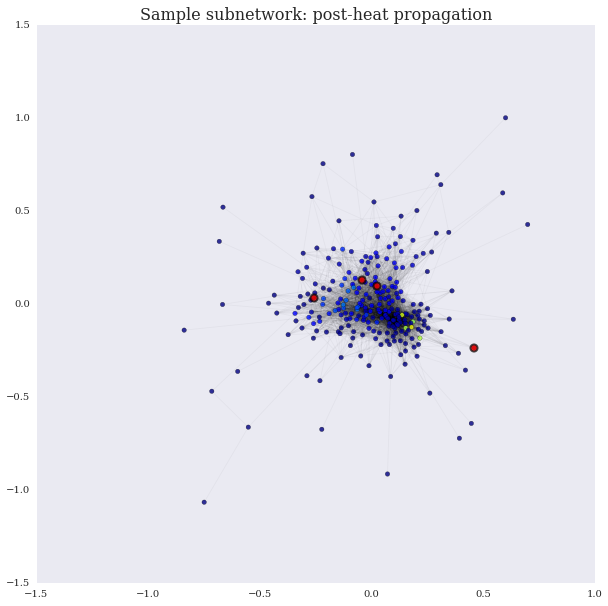

In [39]:
path_to_DB_file = '../drugbank.0.json.new' # set path to drug bank file
path_to_cluster_file = 'sample_matrix.csv' # set path to cluster file
seed_genes = ['LETM1','RPL3','GRK4','RWDD4A'] # set seed genes (must be in cluster)
gene_drug_df = drug_gene_heatprop.drug_gene_heatprop(seed_genes,path_to_DB_file,path_to_cluster_file,
                                                    plot_flag=True)

gene_drug_df.head(25)


# More detailed description of methods below...

## Load the drug bank database, and create a network out of it

- #### Network is bipartite with types:
    1. Drugs
    2. Genes which are acted on by each drug

In [2]:

def load_DB_data(fname):
    '''
    Load and process the drug bank data
    
    '''

    with open(fname, 'r') as f:
        read_data = f.read()
    f.closed

    si = read_data.find('\'\n{\n\t"source":')
    sf = read_data.find('\ncurl')

    DBdict = dict()

    # fill in DBdict
    while si > 0:
        
        db_temp = json.loads(read_data[si+2:sf-2])
        DBdict[db_temp['drugbank_id']]=db_temp

        # update read_data
        read_data = read_data[sf+10:]
        
        si = read_data.find('\'\n{\n\t"source":')
        sf = read_data.find('\ncurl')
        
    return DBdict

In [3]:
DBdict = load_DB_data('/Users/brin/Documents/DrugBank/drugbank.0.json.new')

In [5]:
# make a network out of drug-gene interactions
DB_el = []
for d in DBdict.keys():
    node_list = DBdict[d]['node_list']
    for n in node_list:
        DB_el.append((DBdict[d]['drugbank_id'],n['name']))
    
    

In [6]:
G_DB = nx.Graph()
G_DB.add_edges_from(DB_el)

In [7]:
gene_nodes,drug_nodes = nx.bipartite.sets(G_DB)
gene_nodes = list(gene_nodes)
drug_nodes = list(drug_nodes)

## What is this drug-gene graph like?

- how sparse is it?
- Are there genes/drugs that have many connections?

In [8]:
print('--> there are '+str(len(gene_nodes)) + ' genes with ' + str(len(drug_nodes)) + ' corresponding drugs')

--> there are 3842 genes with 6333 corresponding drugs


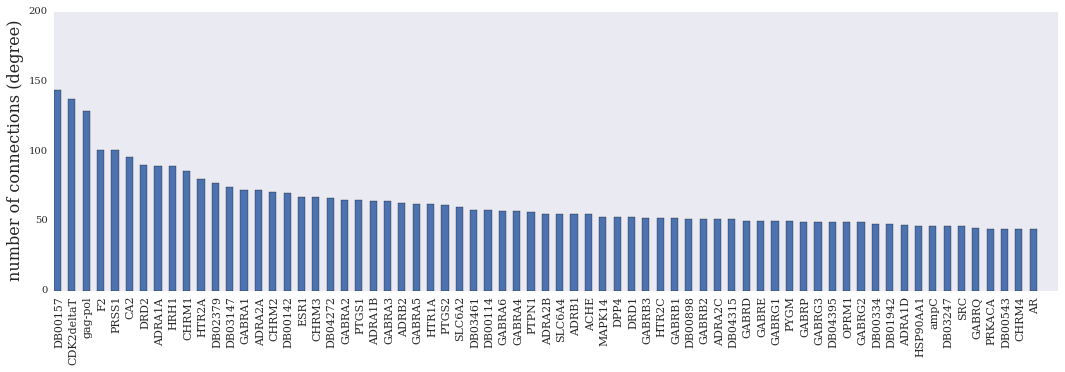

In [9]:
DB_degree = pd.Series(G_DB.degree())
DB_degree.sort(ascending=False)

plt.figure(figsize=(18,5))
plt.bar(np.arange(70),DB_degree.head(70),width=.5)
tmp = plt.xticks(np.arange(70)+.4,list(DB_degree.head(70).index),rotation=90,fontsize=11)
plt.xlim(1,71)
plt.ylim(0,200)
plt.grid('off')
plt.ylabel('number of connections (degree)',fontsize=16)

## But we probably want to focus on within-cluster interactions, instead of the whole graph

- Download a sample cluster from geneli.st (Adrenocortical carcinoma cluster 250250)
- Extract a subnetwork from total drug-gene network containing only the genes from this cluster, and associated drugs
- Plot this subnetwork

In [10]:
# load a sample cluster for network visualization
sample_genes = pd.read_csv('/Users/brin/Documents/DrugBank/sample_cluster.csv',header=None)
sample_genes = list(sample_genes[0])

# also include neighbor genes
neighbor_genes = [nx.neighbors(G_DB,x) for x in sample_genes if x in G_DB.nodes()]
neighbor_genes = [val for sublist in neighbor_genes for val in sublist]
sub_genes = []
sub_genes.extend(sample_genes)
sub_genes.extend(neighbor_genes)

G_DB_sample = nx.subgraph(G_DB,sub_genes)

In [11]:
drug_nodes = list(np.intersect1d(neighbor_genes,G_DB.nodes()))
gene_nodes = list(np.intersect1d(sample_genes,G_DB.nodes()))

In [12]:
# return label positions offset by dx
def calc_pos_labels(pos,dx=.03):
    # input node positions from nx.spring_layout()
    
    pos_labels = dict()
    for key in pos.keys():
        pos_labels[key] = np.array([pos[key][0]+dx,pos[key][1]+dx])
    
    return pos_labels

In [13]:
pos = nx.spring_layout(G_DB_sample,k=.27)
pos_labels = calc_pos_labels(pos)

/Users/brin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/Users/brin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


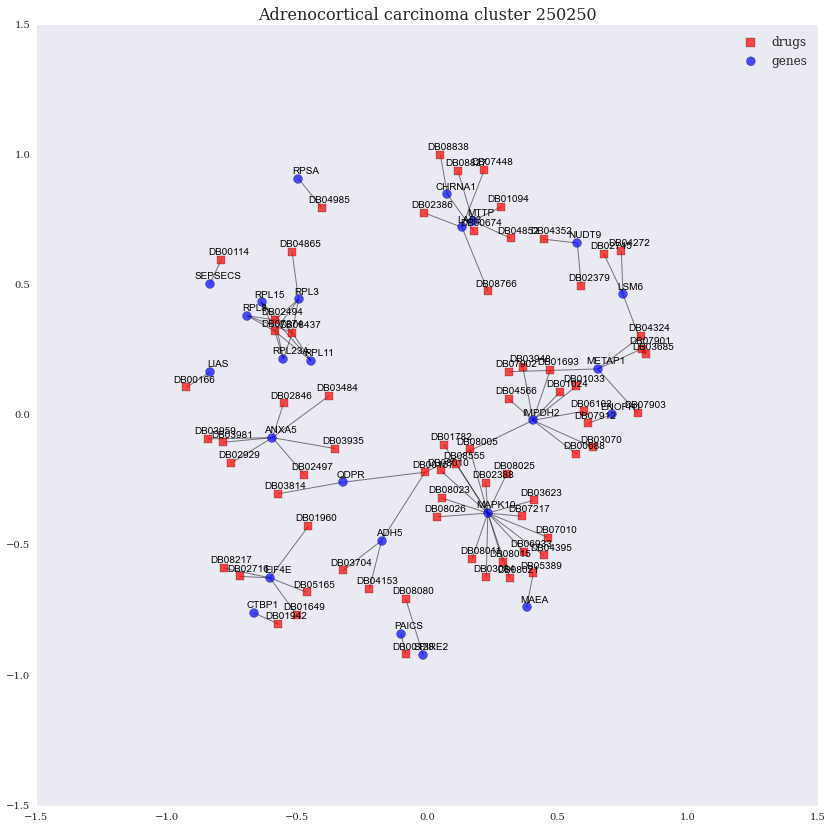

In [14]:
plt.figure(figsize=(14,14))

nx.draw_networkx_nodes(G_DB_sample,pos=pos,nodelist = drug_nodes,node_shape='s',node_size=80,alpha=.7,label='drugs')
nx.draw_networkx_nodes(G_DB_sample,pos=pos,nodelist = gene_nodes,node_shape='o',node_size=80,node_color='blue',alpha=.7,label='genes')
nx.draw_networkx_edges(G_DB_sample,pos=pos,alpha=.5)
nx.draw_networkx_labels(G_DB_sample,pos=pos_labels,font_size=10)
plt.grid('off')

plt.legend(fontsize=12)

plt.title('Adrenocortical carcinoma cluster 250250',fontsize=16)


- #### Above, we plot the drug-gene interaction network for our sample cluster
- #### We're showing only the genes that have associated drugs, in the cluster
- #### This is one option for exploring drug-gene interaction space, as the sparseness of drugs/genes per cluster allows for easy visualization
- #### Another option... heat propagation

# Run heat propagation from seed nodes on a sample cluster, to prioritize genes (and their associated drugs) similar to seed node set

Some questions to resolve:
- ### How should we handle negative edge weights?  
- ### Should we return drugs associated with individual genes, or drugs most associated with total input gene list?


In [30]:
sample_mat = pd.read_csv('/Users/brin/Documents/DrugBank/sample_matrix.csv',index_col=0)

print(sample_mat.head())

idx_to_node = dict(zip(range(len(sample_mat)),list(sample_mat.index)))

sample_mat = np.array(sample_mat)
sample_mat = sample_mat[::-1,0:-1] # reverse the indices for use in graph creation



            FRYL    ADD1  GNPDA2  CDKN2AIP  TRAM1L1  PI4K2B  NHEDC1  TMEM175  \
COQ2      0.5320  0.6872  0.0000    0.5583   0.5451  0.5019  0.0000   0.0000   
SPATA5    0.0000  0.7940  0.0000    0.5663   0.5403  0.0000  0.5556   0.5877   
KIAA1370  0.5049  0.6045  0.5423    0.0000   0.0000  0.0000  0.6052   0.5260   
ZBTB49    0.5459  0.5614  0.0000    0.5331   0.0000  0.5218  0.5156   0.6830   
HTT       0.0000  0.5702  0.0000    0.0000   0.5421  0.5628  0.0000   0.0000   

          OCIAD2  COMMD8      ...        RPL30   RPL31   RPS29  LOC348926  \
COQ2      0.0000  0.0000      ...       0.6653  0.6085  0.6822     0.6950   
SPATA5    0.0000  0.0000      ...       0.6003  0.5748  0.7134     0.5164   
KIAA1370  0.5216  0.0000      ...       0.6855  0.0000  0.5389     0.5424   
ZBTB49    0.5052  0.5041      ...       0.6903  0.6096  0.6701     0.6236   
HTT       0.0000  0.0000      ...       0.6675  0.5430  0.6781     0.7353   

             HTT  ZBTB49  KIAA1370  SPATA5    COQ2  Unna

### First let's plot the focal cluster of interest (Adrenocortical carcinoma cluster 250250)

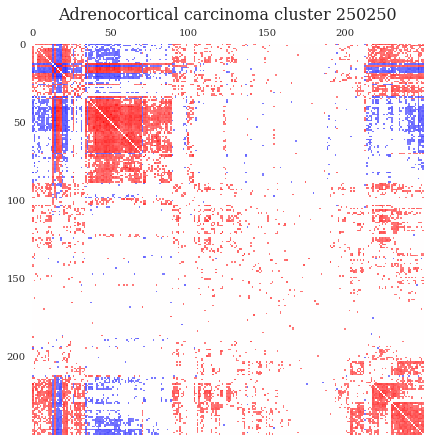

In [16]:
plt.figure(figsize=(7,7))
plt.matshow(sample_mat,cmap='bwr',vmin=-1,vmax=1,fignum=False)
plt.grid('off')
plt.title('Adrenocortical carcinoma cluster 250250',fontsize='16')

- #### Now we will convert the cluster correlation matrix back to network form

In [31]:
G_cluster = nx.Graph()
G_cluster = nx.from_numpy_matrix(np.abs(sample_mat))
G_cluster = nx.relabel_nodes(G_cluster,idx_to_node)


In [18]:
pos = nx.spring_layout(G_cluster,k=.4)

In [19]:
seed_genes = ['STIM2','USP46','FRYL','COQ2'] #['STIM2','USP46'] # input gene list here

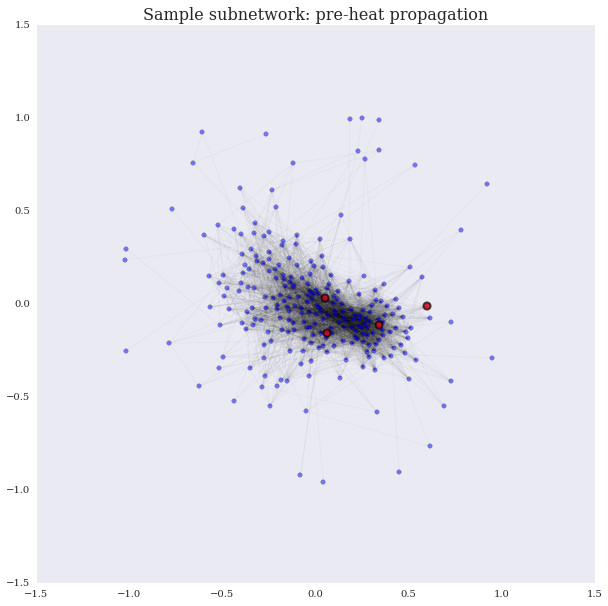

In [20]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G_cluster,pos=pos,node_size=20,alpha=.5,node_color='blue')
nx.draw_networkx_nodes(G_cluster,pos=pos,nodelist=seed_genes,node_size=50,alpha=.7,node_color='red',linewidths=2)
nx.draw_networkx_edges(G_cluster,pos=pos,alpha=.03)
plt.grid('off')
plt.title('Sample subnetwork: pre-heat propagation',fontsize=16)

In [21]:
Wprime = network_prop.normalized_adj_matrix(G_cluster,weighted=True)
Fnew = network_prop.network_propagation(G_cluster,Wprime,seed_genes)

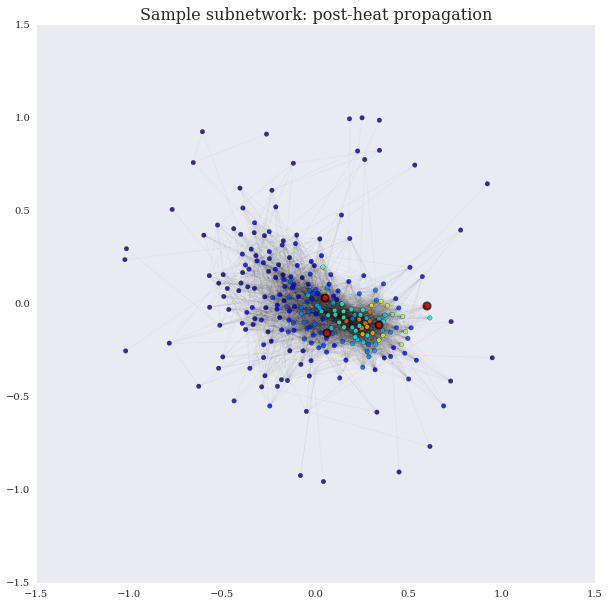

In [22]:
plt.figure(figsize=(10,10))
nx.draw_networkx_edges(G_cluster,pos=pos,alpha=.03)
nx.draw_networkx_nodes(G_cluster,pos=pos,node_size=20,alpha=.8,node_color=Fnew[G_cluster.nodes()],cmap='jet',
                       vmin=0,vmax=.005)
nx.draw_networkx_nodes(G_cluster,pos=pos,nodelist=seed_genes,node_size=50,alpha=.7,node_color='red',linewidths=2)

plt.grid('off')
plt.title('Sample subnetwork: post-heat propagation',fontsize=16)

In [23]:
N = 50

Fnew.sort(ascending=False)
print('Top N hot genes: ')
Fnew.head(N)

Top N hot genes: 


STIM2        0.128134
COQ2         0.126503
FRYL         0.126290
USP46        0.125733
THAP6        0.004011
RPL27        0.003957
LOC285456    0.003862
NAP1L5       0.003846
RPL29        0.003820
PACRGL       0.003738
BCL2L13      0.003564
MAD1L1       0.003542
IMPDH2       0.003423
C4orf52      0.003116
RPL23A       0.003056
WDR19        0.003026
UBE2D3       0.003000
RPS12        0.002946
NUP54        0.002839
TAPT1        0.002716
TRIM61       0.002712
PGRMC2       0.002453
BCAM         0.002431
MRPS18C      0.002173
HES2         0.002146
USP38        0.002132
NAF1         0.002124
EXOC1        0.002120
DGKQ         0.002048
RPL21        0.001994
QDPR         0.001986
FAM13A       0.001912
C20orf199    0.001909
SEPSECS      0.001881
CNO          0.001872
ELF2         0.001863
CRIPAK       0.001862
DCAF16       0.001837
OLA1         0.001831
RPS13        0.001812
SPIRE2       0.001791
C4orf34      0.001767
CDKN2AIP     0.001766
RPS25        0.001766
TMEM33       0.001675
FRG1      

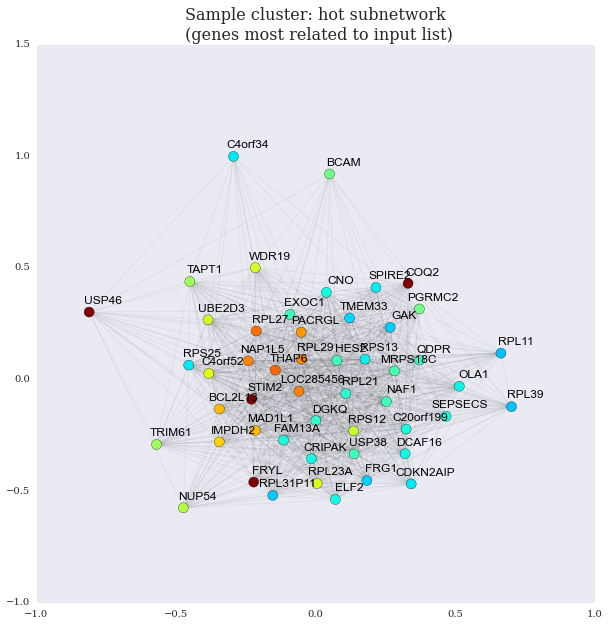

In [24]:
# plot the hot subgraph in gene-gene space

G_cluster_sub = nx.subgraph(G_cluster,list(Fnew.head(N).index))

pos = nx.spring_layout(G_cluster_sub,k=.5)

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G_cluster_sub,pos=pos,node_size=100,node_color=Fnew[G_cluster_sub.nodes()],cmap='jet',
                      vmin=0,vmax=.005)

nx.draw_networkx_edges(G_cluster_sub,pos=pos,alpha=.05)

pos_labels = calc_pos_labels(pos,dx=.05)
nx.draw_networkx_labels(G_cluster_sub,pos=pos_labels)
plt.grid('off')
plt.title('Sample cluster: hot subnetwork \n (genes most related to input list)', fontsize=16)

## Now let's look up the drugs associated with these genes to see if there are any good candidates

In [25]:
top_N_genes = list(Fnew.head(N).index)
top_N_genes = list(np.setdiff1d(top_N_genes,seed_genes)) # only keep non-seed genes
top_N_genes = Fnew[top_N_genes]
top_N_genes.sort(ascending=False)
top_N_genes = list(top_N_genes.index)

drug_candidates_list = seed_genes # build up a list of genes and drugs that may be related to input list
for g in top_N_genes:
    if g in G_DB.nodes():  # check if g is in drugbank graph
        drug_candidates_list.append(g)
        drug_neighs_temp = list(nx.neighbors(G_DB,g))
        drug_candidates_list.extend(drug_neighs_temp)
    
# make a subgraph of these drug/gene candidates
G_DB_sub = nx.subgraph(G_DB,drug_candidates_list)

# define drug_nodes and gene_nodes from the subgraph
drug_nodes = list(np.intersect1d(neighbor_genes,G_DB_sub.nodes()))
gene_nodes = list(np.intersect1d(sample_genes,G_DB_sub.nodes()))


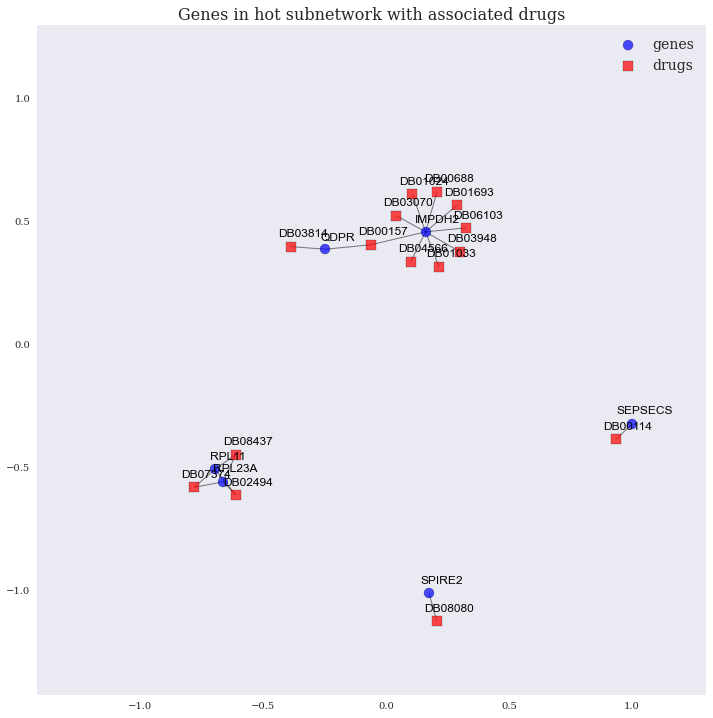

In [26]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G_DB_sub)
pos_labels = calc_pos_labels(pos,dx=.05)

nx.draw_networkx_nodes(G_DB_sub,pos=pos,nodelist=gene_nodes,node_size=100,alpha=.7,node_color='blue',label='genes')
nx.draw_networkx_nodes(G_DB_sub,pos=pos,nodelist=drug_nodes,node_size=100,alpha=.7,node_color='red',node_shape='s',label='drugs')
nx.draw_networkx_edges(G_DB_sub,pos=pos,alpha=.5)
nx.draw_networkx_labels(G_DB_sub,pos=pos_labels,font_color='black')

plt.grid('off')
ax_min = np.min(pos.values())-.3
ax_max = np.max(pos.values())+.3
plt.xlim(ax_min,ax_max)
plt.ylim(ax_min,ax_max)
plt.legend(fontsize=14)
#plt.axes().set_aspect('equal')

plt.title('Genes in hot subnetwork with associated drugs', fontsize=16)
